# Dataset: 'Your Habits' 

<font color=green> I've chosen this one due to its larger sample size and breadth in variety of answer types - could be fun playing with the short text inputs. First, I'll have a look at the data itself and get a feel for what I might want to probe. 

I'm going to tackle this at, largely, survey level as I think this helps in making more generalised remarks, increases the dataset by allowing more features etc (since we are limited on the number of enteries). It also makes it, in some senses, quicker to get going.
    
Following individual groups would be a natural next step and I may gear towards that depending on the data insights as I go. Individual granuality is interesting but I think I won't attempt that this time.
</font>



In [1]:
###### Imports
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import xlrd
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import utils
import os

##### Helper Functions

def importCSV(filePath):
    dataFrame = pd.read_csv(filePath, header=0, low_memory=False)
    return dataFrame

def reIndex(DF):
    DF.reset_index(drop=True, inplace=True)
    return 0

def nullDrop(DF,col):
    return DF.dropna(subset=col)#DF[pd.notnull(DF[col])]

def dfDrop(DF,col,inPlace):
    if(inPlace):
        DF.drop(col, inplace=True, axis=1)
        return 0
    else:
        return DF.drop(col,axis=1)

def makeDict(value,key):
    myDict = value
    myDict.index = key
    return myDict.to_dict()

def mult_n_copy_PD(DF1,DF2,colName,Mult):
    DF1[colName] = DF2[colName] * Mult
    
def normaliseCol(dfCol):
    dfCol_norm = ((dfCol - dfCol.min()) / (dfCol.max() - dfCol.min()))
    return dfCol_norm

def linearFit(X,Y):
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    MSE = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R2 = model_k.score(X,Y)
    return MSE, R2

from sklearn.metrics import confusion_matrix
import itertools

# Excel....

<font color=green> I had hoped this was a CSV dataset but since its an excel sheet spread over named sheets some more effort is needed... </font>

In [2]:
# Load the xl as a pd object
xlFile = pd.ExcelFile('raw.xlsx')

In [3]:
# Have a look at the excel sheets
print(xlFile.sheet_names)

['Survey Summary', 'Data Map', 'Master Data', 'Master Data - Values', '1. Summary', '1. Full raw data', '2. Summary', '2. Full raw data', '3. Summary', '3. Full raw data', '4. Summary', '4. Full raw data', '5. Summary', '5. Full raw data', '6. Summary', '6. Full raw data', '7. Summary', '7. Full raw data', '8. Summary', '8. Full raw data', '9. Summary', '9. Full raw data', '10. Summary', '10. Full raw data', '11. Summary', '11. Full raw data', '12. Summary', '12. Full raw data', '13. Summary', '13. Full raw data', '14. Summary', '14. Full raw data', '15. Summary', '15. Full raw data', '16. Summary', '16. Full raw data', '17. Summary', '17. Full raw data']


<font color=green> Will poke around the sheets to see whats what </font>

In [4]:
print(xlFile.parse('Survey Summary',header=1).head())
print(xlFile.parse('Data Map',header=1).head())
print(xlFile.parse('Master Data',header=0).head())
print(xlFile.parse('Master Data - Values',header=0).head())
print(xlFile.parse('1. Summary',header=0).head())
print(xlFile.parse('1. Full raw data',header=0).head())

  Media Consumption Report 2018
0                   Survey link
  Question #                                              Title Subject  \
0         Q1  Thinking about the last full week, how long di...     NaN   
1        NaN                                                NaN     NaN   
2        NaN                                                NaN     NaN   
3        NaN                                                NaN     NaN   
4        NaN                                                NaN     NaN   

  Response Values Response Codes                  Responses Unnamed: 6  
0   SINGLE_CHOICE          Q1_R1  I do not watch television        NaN  
1             NaN          Q1_R2           Less than 1 hour        NaN  
2             NaN          Q1_R3                  1-2 hours        NaN  
3             NaN          Q1_R4                  3-4 hours        NaN  
4             NaN          Q1_R5                  5-6 hours        NaN  
   Anon. ID  Age  Gender    Home Region  Work R

<font color=green> It is looking like (sheet) [0] is not useful. [1] presents the questions posed and selectable answers. [2],[3] is all of the data with all of the responses, [2] providing a bit map of if a question was answers and [3] providing the corresponding answer.

So we'll press on with [1],[3] as I don't think we need [2] - will drop rows if empty etc. Although it would perhaps be a good idea to hone in on a particular question catergory. Will think about what to focus on... </font>

In [5]:
questionMap = xlFile.parse('Data Map',header=1)
responseDF = xlFile.parse('Master Data - Values',header=0)
responseDF.head()


,Anon. ID,Age,Gender,Home Region,Work Region,Personal Earnings,Household Earnings,Education Level,Relationship Status,Employment Type,...,Q15_R1,Q15_R2,Q15_R3,Q15_R4_Skip,Q15_R5_None,Q16_R1_OE,Q16_R2_NA,Q16_R3_Skip,Q17_R1_OE,Q17_R2_Skip
0,8092,22,Female,North West,NaN,NaN,"Less than £15,000",O Levels or GCSEs,"Single, never married",Temporarily unemployed,...,NaN,NaN,On a PC/Laptop,NaN,NaN,Virgin,NaN,NaN,"Tumblr, Twitter, Spotify",NaN
1,10597,32,Female,Scotland,NaN,NaN,"£40,000 to £44,999",O Levels or GCSEs,Married,Employed part-time,...,NaN,NaN,On a PC/Laptop,NaN,NaN,Netflix,NaN,NaN,"Spotify, Netflix, ITVhub",NaN
2,12575,53,Male,Scotland,NaN,NaN,"£25,000 to £29,999",O Levels or GCSEs,"Single, never married",Employed full-time,...,On your phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"sky, none, none",NaN
3,20488,37,Female,West Midlands,NaN,NaN,"£50,000 to £59,999",Undergraduate Degree: 4 or more years,Married,Employed full-time,...,NaN,NaN,On a PC/Laptop,NaN,NaN,Virgin tv,NaN,NaN,"Virgin, Not sure, Not sure",NaN
4,30653,61,Male,East Midlands,NaN,NaN,"£30,000 to £34,999",NaN,NaN,Retired,...,NaN,NaN,On a PC/Laptop,NaN,NaN,NaN,NaN,NaN,NaN,Skipped


<font color=green> Take a step back and look at the questions and piece together a hypothesis or question to tackle. Lets drop all the rows without values in 'Question #' </font>

In [6]:
questions = questionMap.dropna(subset=['Question #'])
#Pandas does not like 'True' here as it throws a set to copy warning - some sort of chaining problem which is not an issue here
questions = dfDrop(questions,['Subject','Response Values', 'Response Codes', 'Responses'],False)
pd.set_option('display.max_colwidth',-1)
print(questions)


    Question #  \
0    Q1          
7    Q2          
14   Q3          
22   Q4          
32   Q5          
41   Q6          
52   Q7          
59   Q8          
70   Q9          
81   Q10         
84   Q11_S1      
93   Q11_S2      
102  Q11_S3      
111  Q11_S4      
120  Q11_S5      
129  Q11_S6      
138  Q11_S7      
147  Q11_S8      
156  Q12         
159  Q13         
162  Q14         
173  Q15         
178  Q16         
181  Q17         

                                                                                                                                                    Title  \
0    Thinking about the last full week, how long did you spend watching live television each day?                                                           
7    Again thinking about last week, how long did you spend watching streamed television from online providers (such as Netflix or BBC iPlayer) each day?   
14   Which platform do you use most frequently to watch streamed or on-demand 

<font color=green> Q15 is incredibly interesting given the current climate of ad-blocking trends and how this might impact Google/Apple/Amazon etc. especially with native support on iOS Safari etc. 

I think it could be interesting to classify users who are more likely to ad-block by some other parameter, perhaps if they read print newspaper or if they consume more media in a non-linear fashion (online) versus live consumption. So....</font>

# Can we predict if a user will be using Ad Blocking software by their habits or demongraphics?

<font color=green> Need to sort through the data and wrangle into a nicer format. Will seperate out user info first.</font>

In [7]:
#print(responseDF.iloc[11])
responseInfo = responseDF[responseDF.columns[0:16]]
#responseInfo.head()


<font color=green>  Grab the question value from 'Data Map' </font>

In [8]:
questionMap = questionMap.fillna(method='ffill')
respDict = makeDict(questionMap['Responses'],questionMap['Response Codes'])
titleDict = makeDict(questionMap['Title'],questionMap['Response Codes'])

<font color=green>  Before I start removing rows, I can either add the anon ID to keep track or tack responseInfo back on and remove rows like that. I think in the interests of time I'll do the latter. </font>

<font color=green>Q15_R1 -> 'On your phone' -> Phone <br>
Q15_R2 -> 'On a tablet' -> Tablet <br>
Q15_R3 -> 'On a PC/Laptop' -> PC <br>
Q15_R5_None -> 'None' -> None <br>

So lets go back to the bit representation</font>

In [9]:
responseDF = xlFile.parse('Master Data',header=0)

q15DF = responseDF[responseDF.columns[190:195]].copy()
q1_2DF = responseDF[responseDF.columns[17:30]].copy()
q8_9DF = responseDF[responseDF.columns[76:98]].copy()
q13DF = responseDF[responseDF.columns[176:179]].copy()

qDF = pd.concat([responseInfo,q1_2DF,q8_9DF,q13DF,q15DF], axis=1)
## So we want to *keep* the Q15_R4_Skip NaN and then drop the col

qDF = qDF[qDF['Q15_R4_Skip']==0]
qDF = dfDrop(qDF,['Q15_R4_Skip'],False)

print("{} non-null/skipped enteries".format(qDF.shape[0]))

qDF

984 non-null/skipped enteries


,Anon. ID,Age,Gender,Home Region,Work Region,Personal Earnings,Household Earnings,Education Level,Relationship Status,Employment Type,...,Q9_R9_Skip,Q9_R10_None,Q9_R11_OE,Q13_R1_OE,Q13_R2_NA,Q13_R3_Skip,Q15_R1,Q15_R2,Q15_R3,Q15_R5_None
0,8092,22,Female,North West,NaN,NaN,"Less than £15,000",O Levels or GCSEs,"Single, never married",Temporarily unemployed,...,0,1,0,"Na, Na, Na",0,0,0,0,1,0
1,10597,32,Female,Scotland,NaN,NaN,"£40,000 to £44,999",O Levels or GCSEs,Married,Employed part-time,...,0,1,0,"Take a break, Heat, Woman’s own",0,0,0,0,1,0
2,12575,53,Male,Scotland,NaN,NaN,"£25,000 to £29,999",O Levels or GCSEs,"Single, never married",Employed full-time,...,0,0,0,NaN,1,0,1,0,0,0
3,20488,37,Female,West Midlands,NaN,NaN,"£50,000 to £59,999",Undergraduate Degree: 4 or more years,Married,Employed full-time,...,0,0,0,"Grazia, Hello, Now",0,0,0,0,1,0
4,30653,61,Male,East Midlands,NaN,NaN,"£30,000 to £34,999",NaN,NaN,Retired,...,0,1,0,NaN,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9948093,59,Female,South West,NaN,NaN,"Less than £15,000",A Levels equivalent,Married,Full-time homemaker,...,0,0,0,"Practical motorhome, Slimming world, Tv times",0,0,0,0,1,0
996,9956822,47,Male,Yorkshire & Humber,NaN,NaN,"£20,000 to £24,999",Post Graduate: other/not PhD or MA,Married,Employed full-time,...,0,0,0,"national gepgraphic, dr who magazine, n/a",0,0,0,0,0,1
997,9987928,18,Male,Scotland,NaN,NaN,"£60,000 to £74,999",A Levels,"Single, never married",Employed part-time,...,0,0,0,NaN,1,0,1,0,0,0
998,9988227,35,Female,East Midlands,NaN,NaN,"£35,000 to £39,999",Undergraduate Degree: 4 or more years,Married,Temporarily unemployed,...,0,0,0,NaN,1,0,1,0,0,0


In [10]:
##### Quick and dirty way to get gender and education level. 
##### Dictionary/hashmap would have been better...

r2 = pd.get_dummies(responseDF,columns=['Education Level','Gender'])
isMale = r2['Gender_Male']
isMale


r2['Education Level_None']*= 0
r2['Education Level_Below O Level or GCSE']*= 1
r2['Education Level_O Levels or GCSEs equivalent']*= 2
r2['Education Level_O Levels or GCSEs']*= 2
r2['Education Level_A Levels']*= 3
r2['Education Level_A Levels equivalent']*= 3
r2['Education Level_Undergraduate Degree: less than 2 years']*= 4
r2['Education Level_Undergraduate Degree: 3 years']*= 5
r2['Education Level_Undergraduate Degree: 4 or more years']*= 6
r2['Education Level_Post Graduate: other/not PhD or MA']*= 7
r2['Education Level_Post Graduate: MA']*= 7
r2['Education Level_Post Graduate: PhD']*= 8

education = r2[r2.columns[198:210]].sum(axis=1)

<font color=green> Could use pandas to quickily convert catergorical data into ints and intertools to go over combintations to find the best subset to go ahead with. However this will take some time...</font>
    pd.get_dummies()<br>
    itertools.combinations()

<font color=green>Q1 -> live TV hours.    Will convert to binary and keep the sum hours <br>
Q2 -> stream TV hours   Will convert to binary and keep a lot of the sum hours <br>
Q8 -> Print newspapaers Binary again but with a count perhaps though probably not a good metric <br>
Q9-> web newspapers  Binary <br>
Q13 -> Print/Web Mag  So this question is a bit vague compared to the others... Will have binary and count for now <br><font> <br>
<font color=green>
    1, 2 are single choice<br>
    8, 9 are multiple choice<br>
    13 is free text - some rudimentary treatment of this for the time being<br>
    <font>

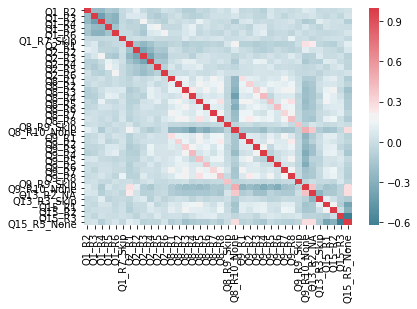

In [11]:
corr = qDF[qDF.columns[17:]].corr()
heatPlot = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))


<font color=green>Probbaly jumping the gun here and unsuprisingly not overly useful/clear at this stage. Overally, good spread of dark red and blues so there is some promising correlations amongst these questions. I won't filter by demographic at this stage. 


Make the answers less messy and reduce dimensions</font>

## Cue some messy wrangling...

In [12]:
####### Question 1: Live TV per day

# q1_2DF = responseDF[responseDF.columns[17:30]]

#Q1_R1	I do not watch television
#Q1_R2	Less than 1 hour
#Q1_R3	1-2 hours
#Q1_R4	3-4 hours
#Q1_R5	5-6 hours
#Q1_R6	More than 6 hours
#Q1_R7_Skip	Skipped

#17 and 23 are equiv, assumption

#q1['Q1_R1'] = q1['Q1_R1'].apply(lambda x: x*1)

### Perhaps a bit 'wasteful' to do this on a copy
q1 = responseDF[responseDF.columns[17:24]].copy()
q1.loc[:,'Q1_R1'] *= 0
q1.loc[:,'Q1_R2'] *= 1
q1.loc[:,'Q1_R3'] *= 2
q1.loc[:,'Q1_R4'] *= 4
q1.loc[:,'Q1_R5'] *= 6
q1.loc[:,'Q1_R6'] *= 10
q1.loc[:,'Q1_R7_Skip'] *= 0
q1['total'] = q1.sum(axis=1)


In [13]:
####### Question 2: Non-live TV per day

q2 = responseDF[responseDF.columns[24:31]].copy()
q2.loc[:,'Q2_R1'] *= 0
q2.loc[:,'Q2_R2'] *= 1
q2.loc[:,'Q2_R3'] *= 2
q2.loc[:,'Q2_R4'] *= 4
q2.loc[:,'Q2_R5'] *= 6
q2.loc[:,'Q2_R6'] *= 10
q2.loc[:,'Q2_R7_Skip'] *= 0
q2['total'] = q2.sum(axis=1)



In [14]:
# Q8 Print Media

# 87 is FT for later
# 85, 86 is None or Skip -> assume these are 0, save for later

#SUM THIS WITH NUMBER OF PRINT READS

### Assuming no nonsene input with CSV
q8 = qDF['Q8_R11_OE'].str.split(',', expand=True)
columns = list(q8) 
for i in columns:
    q8[i] = q8[i].str.len() > 3
q8['Other'] = q8.sum(axis=1)

q8['Reads'] = responseDF[responseDF.columns[76:84]].sum(axis=1) # Number of print reads
#q8['NonReads'] = responseDF[responseDF.columns[84:86]].sum(axis=1) # Does not read print

q8['total'] = q8.sum(axis=1)


In [15]:
#### Q9 Digitial Newspapers

#97, 96 are 'nones'

q9 = pd.DataFrame()
q9['Reads'] = responseDF[responseDF.columns[87:95]].sum(axis=1) ### number of digital newspapers
### + 1 if 
q9['OtherReads'] = responseDF['Q9_R11_OE'][responseDF['Q9_R11_OE']!=0]
#q9['Non-Reads'] =responseDF[responseDF.columns[95:97]].sum(axis=1) ### does not read digital newspapers

q9['total'] = q9.sum(axis=1)


In [16]:
###### QUESTION 13

q13 = qDF['Q13_R1_OE'].str.split(',', expand=True)

columns = list(q13) 
for i in columns:
    q13[i] = q13[i].str.len() > 3
q13['total'] = q13.sum(axis=1)
    

In [17]:
q15 = pd.DataFrame()
dfDrop(q15DF,['Q15_R4_Skip','Q15_R5_None'],True)
q15['total'] = q15DF.sum(axis=1)


In [18]:
######### Social Media Interaction - Q11 

s_amountDict  = {'R1': 16,'R2': 6,'R3': 2,'R4': 1,'R5':2.5/7,'R6': 1/7,'R7': 1/30,'R8': 0,'R9_Skip': 0}
s_que = ['S1','S2','S3','S4','S5','S6','S7','S8']
s_amount = ['R1','R2','R3','R4','R5','R6','R7','R8','R9_Skip']

q11 = pd.DataFrame()

for i in s_que:
    for j in s_amount:
        mult_n_copy_PD(q11,responseDF,'Q11_'+i+'_'+j ,s_amountDict[j])

q11['total'] = q11.sum(axis=1)

In [19]:
finalDF = responseInfo.copy()


finalDF = dfDrop(finalDF,['Work Region','Personal Earnings'],False)

finalDF.insert(14, "linear_TV",normaliseCol(q1['total']))
finalDF.insert(15, "non_linear_TV",normaliseCol(q2['total']))
finalDF.insert(16, "print_news",normaliseCol(q8['total']))
finalDF.insert(17, "web_news",normaliseCol(q9['total']))
finalDF.insert(18, "magazine",normaliseCol(q13['total']))
finalDF.insert(19, "socialEngagement",normaliseCol(q11['total']))
finalDF.insert(20, "education",normaliseCol(education))
finalDF.insert(21,"isMale",normaliseCol(isMale))

finalDF = nullDrop(finalDF,['Household Earnings'])

temp = finalDF['Household Earnings'].str.split('£', expand=True)
temp = temp[1].str.split(' to ', expand=True)
temp = temp[0].str.replace(',', '')
temp = temp.str.replace(' and above', '')

finalDF.insert(22, "householdEarning",normaliseCol(temp.astype(int)))
finalDF.insert(23, "age",normaliseCol(finalDF['Age']))
finalDF.insert(24,"adBlock",normaliseCol(q15['total']))

In [20]:
fDF = finalDF[finalDF.columns[14:]].dropna()

y = fDF.adBlock
X = dfDrop(fDF,['adBlock'],False)

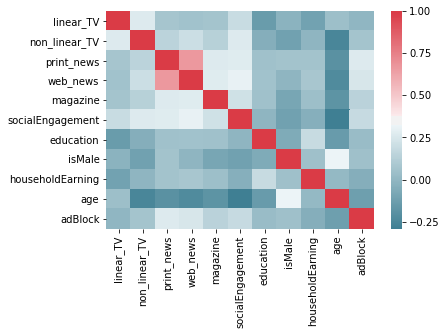

In [21]:
corr = fDF.corr()
heatPlot = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))


## Linear Regression

<font color=green>Want to check not only the pair-wise relations but also check different combintations of features for a linear pattern. Could do this by eye but easier/faster to automate it with mean squared error (MSE) and R^2 (R2) as metrics. It is perhaps a bit obvious what will happen here from the correlation heatmap above but lets try anyhow.</font>

In [22]:
import itertools
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


In [24]:

k = 10
mseList, r2List, featureList = [],[], []
numberFeatures = []

for k in range(1,len(X.columns)):
    for combins in itertools.combinations(X.columns,k):
        tmp_result = linearFit(X[list(combins)],y)   #Store temp result 
        mseList.append(tmp_result[0])                  #Append lists
        r2List.append(tmp_result[1])
        featureList.append(combins)
        numberFeatures.append(len(combins))   

#Store in DataFrame
df = pd.DataFrame({'numberOfFeatures': numberFeatures,'MSE': mseList, 'R2':r2List,'features':featureList})


,numberOfFeatures,MSE,R2,features
2,1,59.368515,0.073033,"(print_news,)"
29,2,58.544666,0.085896,"(print_news, socialEngagement)"
120,3,58.212743,0.091079,"(print_news, web_news, socialEngagement)"


,numberOfFeatures,MSE,R2,features
2,1,59.368515,0.073033,"(print_news,)"
29,2,58.544666,0.085896,"(print_news, socialEngagement)"
120,3,58.212743,0.091079,"(print_news, web_news, socialEngagement)"


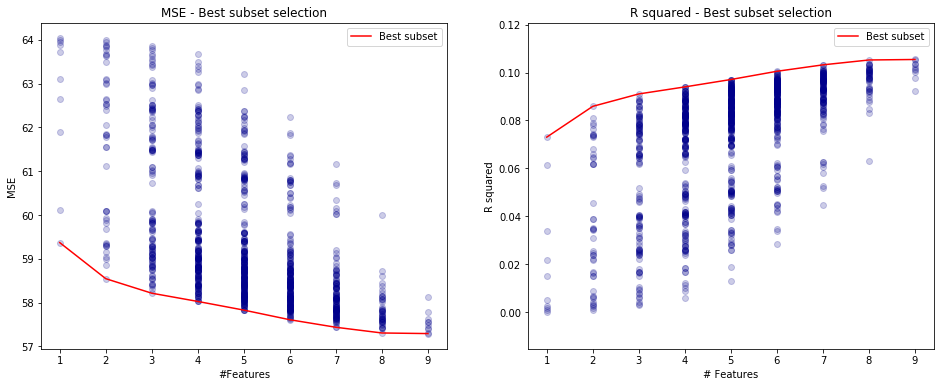

In [25]:

#Thank you https://xavierbourretsicotte.github.io/subset_selection.html for plotting code

df_min = df[df.groupby('numberOfFeatures')['MSE'].transform(min) == df['MSE']]
df_max = df[df.groupby('numberOfFeatures')['R2'].transform(max) == df['R2']]
display(df_min.head(3))
display(df_max.head(3))

df['minMSE'] = df.groupby('numberOfFeatures')['MSE'].transform(min)
df['maxR2'] = df.groupby('numberOfFeatures')['R2'].transform(max)
df.head()


fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numberOfFeatures,df.MSE, alpha = .2, color = 'darkblue' )
ax.set_xlabel('#Features')
ax.set_ylabel('MSE')
ax.set_title('MSE - Best subset selection')
ax.plot(df.numberOfFeatures,df.minMSE,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numberOfFeatures,df.R2, alpha = .2, color = 'darkblue' )
ax.plot(df.numberOfFeatures,df.maxR2,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R squared - Best subset selection')
ax.legend()

plt.show()


## Logistic Regression

0.6344086021505376
[[ 8 17  0  0]
 [ 3 51  0  0]
 [ 2  8  0  1]
 [ 2  1  0  0]]


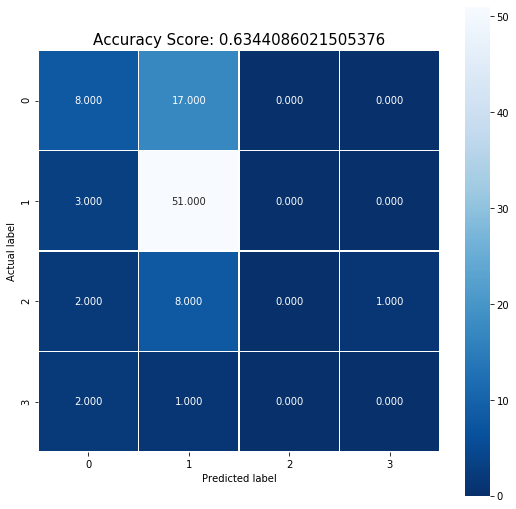

In [26]:


from sklearn.linear_model import LogisticRegression

lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
logit = LogisticRegression()
logit.fit(x_train, y_train)
score = logit.score(x_test, y_test)

print(score)
predictions = logit.predict(x_test)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# K-means

<font color=green>Out of curiosity do we have a meaningul clustering going on with these feautres? We can see the elbow method suggesting quite a high number of clusters which suggests that either we need a larger dataset or more features if we are to get any meaningful groupings. </font>

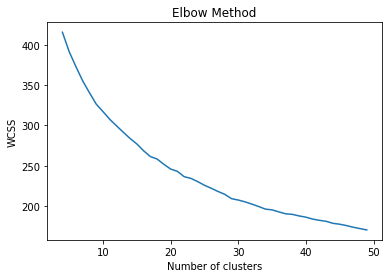

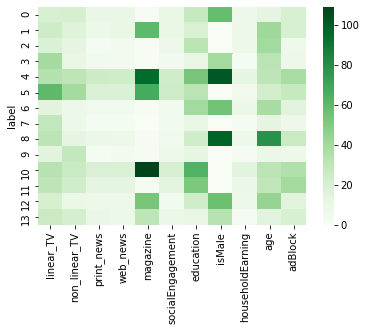

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

wcss = []
cluster_max = 50
cluster_min = 4
for i in range(cluster_min, cluster_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=600, n_init=10, random_state=0)
    kmeans.fit(fDF)
    wcss.append(kmeans.inertia_)
    
    preds = kmeans.fit_predict(fDF)
    score = silhouette_score (fDF, preds, metric='euclidean')
    #print ("For n_clusters = {}, silhouette score is {})".format(kmeans.n_clusters, score))

plt.plot(range(cluster_min, cluster_max), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

cluster_optim = 14
kmeans = KMeans(n_clusters=cluster_optim, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(fDF)
fDF['label'] = kmeans.labels_

fDF_temp = fDF.groupby(['label']).sum()
fig, ax = plt.subplots()
HM = sns.heatmap(fDF_temp,cmap="Greens")
figHM = HM.get_figure()



<font color=green>We tried it, not overly useful in terms of the significance of clusters and we don't immediately see a pattern emerging from the data.


This is could be quite a good problem for logsitic regression so we could try that next...
</font>

## Random Forest

<font color=green>
We could see from the correlation matrix that linear regression would not cut it for this problem, we confirmed by running lin reg over a combination of features. Logisitic regression comes up pretty well with around 60% accuracy. 

What might perform better is a random forest. Decision trees have issues with over-fitting etc, so a random forest should alleviate some of these issues. Boosting/Bagging can be used to further optimise things.</font>

In [28]:
#### Adapted from https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb


def modelEval(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    

Average number of nodes 323
Average maximum depth 16
Recall Baseline: 1.0 Test: 0.9 Train: 1.0
Precision Baseline: 0.72 Test: 0.78 Train: 1.0
Roc Baseline: 0.5 Test: 0.74 Train: 1.0


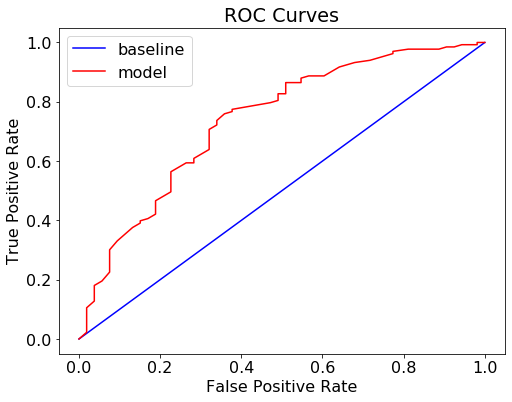

In [29]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

randState = 25

# Simplyfy the labels of does/does not adblock
labels = y
labels[labels>0] = 1

# 20/80 split
train, test, train_labels, test_labels = train_test_split(X, labels, stratify = labels, test_size = 0.2,random_state = randState)

# classification problem so we want sqrt(features) in max_features
model = RandomForestClassifier(n_estimators=100,random_state=randState,max_features = 'sqrt')

# Fit!
model.fit(train, train_labels)

###### Look at the forest

n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

train_predictions = model.predict(train)
train_probs = model.predict_proba(train)[:, 1]

predictions = model.predict(test)
probs = model.predict_proba(test)[:, 1]

modelEval(predictions, probs, train_predictions, train_probs)



Text(0.5, -44.561629599226606, 'Predicted label')

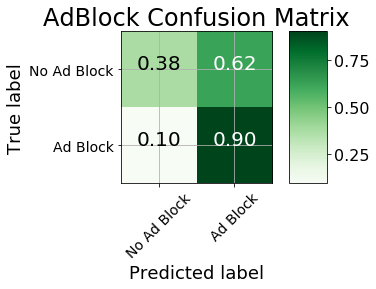

In [32]:
cm = confusion_matrix(test_labels, predictions)

                      
labels = ['No Ad Block', 'Ad Block']
title = 'AdBlock Confusion Matrix'


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title(title, size = 24)
plt.colorbar(aspect=4)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, size = 14)
plt.yticks(tick_marks, labels, size = 14)

fmt = '.2f'
thresh = cm.max() / 2.

# Labeling the plot
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)

In [33]:
features = list(train.columns)

fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
5,socialEngagement,0.204690
9,age,0.174135
8,householdEarning,0.114247
2,print_news,0.099897
6,education,0.094850
0,linear_TV,0.086527
3,web_news,0.080537
1,non_linear_TV,0.078371
4,magazine,0.041032
7,isMale,0.025714


# Future / Reflection

<font color=green> We can see, clearly, that we dont have a linear relationship and a logit model and, better, a forest serves as a decent predictor. Including more features with more nuanced free text analysis would give the models more parameters to play with. Some of the feature wrangling is rather rudimentary and makes some assumptions which perhaps could be removed. For example, the lumping together of social interactions is causing some information loss.</font>
    
   <font color=green> Through doing this, I realised that perhaps some of the initial data manipulation may have been somewhat uneccasry since a binary map (for the most part) was already provided. Analysis that uses this data would aid in automation/generalisation. </font>